# Project 1: JPEG Compression - ELEC 5306

This file is the template for Project 1.

Please follow the instruction, code and text where it is required, and run through this file.

The original code is forked from a well-developed repo: https://github.com/ghallak/jpeg-python.

In [28]:
# get the test image for this project
!wget https://www.dropbox.com/s/ghmj28pcj694ytc/airplane.png?dl=0 -O airplane.png

--2022-04-08 10:54:22--  https://www.dropbox.com/s/ghmj28pcj694ytc/airplane.png?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ghmj28pcj694ytc/airplane.png [following]
--2022-04-08 10:54:22--  https://www.dropbox.com/s/raw/ghmj28pcj694ytc/airplane.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce8e230c114124307b64f254c66.dl.dropboxusercontent.com/cd/0/inline/BjCK29Esizc900kCezTxjtG-xeNkRgM5mai57KhRlWhffmHraN-ONa0H-tujwt4P32yyxhtr1a0923cLv2DI7C-b9hu7kPKVhqmaV-Ekb6JC4093TUW_YpvRiENN22aTTFBPY2j3mocjObpUMp2tGTB9Fh4IY8Ctc63lc34t1NBs1w/file# [following]
--2022-04-08 10:54:23--  https://uce8e230c114124307b64f254c66.dl.dropboxusercontent.com/cd/0/inline/BjCK29Esizc900kCezTxjtG-xeNkRgM5mai57KhRlWhffmHraN-ONa0H-tuj

In [29]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

import argparse
import os
import sys
import math
import numpy as np

from scipy import fftpack
from PIL import Image


In [30]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# This cell defines a HuffmanTree class

from queue import PriorityQueue


class HuffmanTree:

    class __Node:
        def __init__(self, value, freq, left_child, right_child):
            self.value = value
            self.freq = freq
            self.left_child = left_child
            self.right_child = right_child

        @classmethod
        def init_leaf(self, value, freq):
            return self(value, freq, None, None)

        @classmethod
        def init_node(self, left_child, right_child):
            freq = left_child.freq + right_child.freq
            return self(None, freq, left_child, right_child)

        def is_leaf(self):
            return self.value is not None

        def __eq__(self, other):
            stup = self.value, self.freq, self.left_child, self.right_child
            otup = other.value, other.freq, other.left_child, other.right_child
            return stup == otup

        def __nq__(self, other):
            return not (self == other)

        def __lt__(self, other):
            return self.freq < other.freq

        def __le__(self, other):
            return self.freq < other.freq or self.freq == other.freq

        def __gt__(self, other):
            return not (self <= other)

        def __ge__(self, other):
            return not (self < other)

    def __init__(self, arr):
        q = PriorityQueue()

        # calculate frequencies and insert them into a priority queue
        for val, freq in self.__calc_freq(arr).items():
            q.put(self.__Node.init_leaf(val, freq))

        while q.qsize() >= 2:
            u = q.get()
            v = q.get()

            q.put(self.__Node.init_node(u, v))

        self.__root = q.get()

        # dictionaries to store huffman table
        self.__value_to_bitstring = dict()

    def value_to_bitstring_table(self):
        if len(self.__value_to_bitstring.keys()) == 0:
            self.__create_huffman_table()
        return self.__value_to_bitstring

    def __create_huffman_table(self):
        def tree_traverse(current_node, bitstring=''):
            if current_node is None:
                return
            if current_node.is_leaf():
                self.__value_to_bitstring[current_node.value] = bitstring
                return
            tree_traverse(current_node.left_child, bitstring + '0')
            tree_traverse(current_node.right_child, bitstring + '1')

        tree_traverse(self.__root)

    def __calc_freq(self, arr):
        freq_dict = dict()
        for elem in arr:
            if elem in freq_dict:
                freq_dict[elem] += 1
            else:
                freq_dict[elem] = 1
        return freq_dict


In [31]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# This cell contains necessary functions for encoding

import numpy as np


def zigzag_points(rows, cols):
    # constants for directions
    UP, DOWN, RIGHT, LEFT, UP_RIGHT, DOWN_LEFT = range(6)

    # move the point in different directions
    def move(direction, point):
        return {
            UP: lambda point: (point[0] - 1, point[1]),
            DOWN: lambda point: (point[0] + 1, point[1]),
            LEFT: lambda point: (point[0], point[1] - 1),
            RIGHT: lambda point: (point[0], point[1] + 1),
            UP_RIGHT: lambda point: move(UP, move(RIGHT, point)),
            DOWN_LEFT: lambda point: move(DOWN, move(LEFT, point))
        }[direction](point)

    # return true if point is inside the block bounds
    def inbounds(point):
        return 0 <= point[0] < rows and 0 <= point[1] < cols

    # start in the top-left cell
    point = (0, 0)

    # True when moving up-right, False when moving down-left
    move_up = True

    for i in range(rows * cols):
        yield point
        if move_up:
            if inbounds(move(UP_RIGHT, point)):
                point = move(UP_RIGHT, point)
            else:
                move_up = False
                if inbounds(move(RIGHT, point)):
                    point = move(RIGHT, point)
                else:
                    point = move(DOWN, point)
        else:
            if inbounds(move(DOWN_LEFT, point)):
                point = move(DOWN_LEFT, point)
            else:
                move_up = True
                if inbounds(move(DOWN, point)):
                    point = move(DOWN, point)
                else:
                    point = move(RIGHT, point)


def bits_required(n):
    n = abs(n)
    result = 0
    while n > 0:
        n >>= 1
        result += 1
    return result


def binstr_flip(binstr):
    # check if binstr is a binary string
    if not set(binstr).issubset('01'):
        raise ValueError("binstr should have only '0's and '1's")
    return ''.join(map(lambda c: '0' if c == '1' else '1', binstr))


def uint_to_binstr(number, size):
    return bin(number)[2:][-size:].zfill(size)


def int_to_binstr(n):
    if n == 0:
        return ''

    binstr = bin(abs(n))[2:]

    # change every 0 to 1 and vice verse when n is negative
    return binstr if n > 0 else binstr_flip(binstr)


def flatten(lst):
    return [item for sublist in lst for item in sublist]
    

def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])
    

def write_to_file(filepath, dc, ac, blocks_count, tables):
    try:
        f = open(filepath, 'w')
    except FileNotFoundError as e:
        raise FileNotFoundError(
                "No such directory: {}".format(
                    os.path.dirname(filepath))) from e

    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name in {'dc_y', 'dc_c'}:
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))

    for b in range(blocks_count):
        for c in range(3):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] if c == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if c == 0 else tables['ac_c']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))

            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
    f.close()


In [32]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# This cell contains necessary functions for encoding

class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0

        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        # TODO: break the loop if __read_char is not returing new char
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        if size <= 0:
            raise ValueError("size of unsigned int should be greater than 0")
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(3):
            dc_table = tables['dc_y'] if component == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if component == 0 else tables['ac_c']

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)

            cells_count = 0

            # TODO: try to make reading AC coefficients better
            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block


def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q


def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')


## Q1: 2D discrete cosine transform

**TARGET**: Re-implement the 2D DCT `fftpack.dct(x, type=2, norm='ortho)`

**REFERENCE**: Type II in https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html

**EXAMPLE**: Here is an example for re-implementing `fftpack.dct(x, type=1, norm=None)` and validation.

In [33]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# Example of a 2D DCT

def dct_2d_type_1_norm_none(image):

    def vec_cos(k, N):
        return np.cos((math.pi * k * np.arange(1, N-1)) / (N - 1))

    yk = np.zeros_like(image).astype(np.float32)
    for row, row_img in enumerate(image):
        vec_xn = row_img.astype(np.float32)
        vec_yk = np.zeros_like(vec_xn)
        for k in range(len(vec_yk)):
            vec_yk[k] = vec_xn[0] + (-1) ** k * vec_xn[-1] + 2 * np.sum(vec_xn[1:-1] * vec_cos(k, len(vec_xn)))
        yk[row] = vec_yk

    return yk

rnd_img = np.random.randint(0, 256, size=(4, 4))

print(fftpack.dct(rnd_img, type=1))
print(dct_2d_type_1_norm_none(rnd_img))

[[ 957. -228.   60.  357.]
 [ 896.  262.  -76.  166.]
 [1158.  152. -174.  152.]
 [ 307.  -40.  226.   -7.]]
[[ 957. -228.   60.  357.]
 [ 896.  262.  -76.  166.]
 [1158.  152. -174.  152.]
 [ 307.  -40.  226.   -7.]]


### Solution: 

Write your code below

In [34]:
##########################
# !!!!!!!!! EDIT REQUIRED !!!!!!!!!!
##########################

# Complete this function
def dct_2d_type_2_norm_ortho(image):
  def vec_cos(k, N):       # representing the cosine part during summing (after sigma symbol)
        return np.cos( (math.pi * k * (2*np.arange(0, N)+1)) / (2*N) )

  yk = np.zeros_like(image).astype(np.float32)  # make all the pixel values in the image as 0
  for row, row_img in enumerate(image):
      vec_xn = row_img.astype(np.float32)   # each row in image matrix, represents the x in the equation
      vec_yk = np.zeros_like(vec_xn)      # yk is what we want to calculate after DCT (left part of the equation)
      
      for k in range(len(vec_yk)):      # in the length of each row
        # Because is it "ortho" type, we will have two different equations based on different k values
        if k == 0:
          vec_yk[k] = np.sqrt(1/(4*len(vec_xn))) * 2 * np.sum(vec_xn[0:len(vec_yk)] * vec_cos(k, len(vec_xn))) # n is from 0 to N-1 --> [0:len(vec_yk)]
        else:
          vec_yk[k] = np.sqrt(1/(2*len(vec_xn))) * 2 * np.sum(vec_xn[0:len(vec_yk)] * vec_cos(k, len(vec_xn)))
      yk[row] = vec_yk

  return yk
  # return img_dct

# for validation
# 1. define a image w/ random content
rnd_img = np.random.randint(0, 256, size=(4, 4))
# 2. get result from the original function
print(fftpack.dct(rnd_img, norm='ortho'))
# 3. get result from your written function
print(dct_2d_type_2_norm_ortho(rnd_img))
# 4. compare the output and check if they're the same

[[ 207.5        -100.99133121  114.5         -96.17302647]
 [ 243.          -45.02066265  -56.         -174.0176426 ]
 [ 171.5          47.6942144  -139.5         -56.01572916]
 [ 393.5          -5.81387525  -63.5           2.94938208]]
[[ 207.5      -100.99133   114.5       -96.17303 ]
 [ 243.        -45.020664  -56.       -174.01764 ]
 [ 171.5        47.694214 -139.5       -56.015728]
 [ 393.5        -5.813875  -63.5         2.949382]]


The result after the above code shows that the two functions will return the same values (except the decimal used), which means the function that we made is correct.

In [35]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines a dct_2d function for the image, and is based on your function

def dct_2d(image):
  return dct_2d_type_2_norm_ortho(dct_2d_type_2_norm_ortho(image.T).T)

# if cannot figure out the dct function, uncomment below

#def dct_2d(image):
#  return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')

## Q2: run-length coding
**TARGET**: 
1. explain the meaning of items of `symbols` and `values` that are returned by `run_length_encode` below.
2. figure out the original array. The `symbols` of this array is: (length is 26)

```
[(0, 2), (0, 3), (1, 2), (0, 2), (0, 2), (2, 2), (0, 3), (0, 1), (0, 1), (1, 1), (0, 1), (0, 1), (1, 1), (0, 2), (0, 2), (0, 3), (0, 3), (0, 2), (0, 2), (0, 2), (0, 3), (0, 2), (1, 2), (0, 2), (0, 2), (0, 2)]
```
And the `values` of this array is : (length is 26)
```
['10', '100', '11', '10', '10', '11', '100', '1', '1', '1', '1', '1', '1', '11', '10', '100', '100', '11', '11', '10', '100', '11', '11', '11', '10', '11']
```

In [36]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines a run length encoder

def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            last_nonzero = i

    symbols = []

    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            break
        elif elem == 0 and run_length < 15: #if current element=0，only increase the value of run-length，which will be used in the next element
        # for example, 0,0,2 --> (2,0) --> (2，2)
            run_length += 1
        else:
            size = bits_required(elem)  # the binary bit required to represent the non-zero  integer (no matter positive or negative)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))
            run_length = 0
    return symbols, values

arr = np.random.randint(0, 15, size=(16,))
ss, vv = run_length_encode(arr)
print('original array: {}\n symbols: {}\n values: {}\n'.format(arr, ss, vv))

original array: [10  7  7  2  4  0  2  1 11  9 14  8 14  1  7 12]
 symbols: [(0, 4), (0, 3), (0, 3), (0, 2), (0, 3), (1, 2), (0, 1), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 1), (0, 3), (0, 4)]
 values: ['1010', '111', '111', '10', '100', '10', '1', '1011', '1001', '1110', '1000', '1110', '1', '111', '1100']



### Solution:

1.
As for the 'symbols', they represent the results after run-length coding. 
There are 2 elements in every group of 'symbol'.The first element means the number of '0'. The other element is the size (binary bits needed) of the next nonzero value.

As for the 'values', we use binary numbers to represent all the non-zero values.

2.
The original array (sequence) is: 2, 4, 0, 3, 2, 2, 0, 0, 3, 4, 1, 1, 0, 1, 1, 1, 0, 1, 3, 2, 4, 4, 3, 3, 2, 4, 3, 0, 3, 3, 2, 3 by using the code below:

In [37]:
val_1 =['10', '100', '11', '10', '10', '11', '100', '1', '1', '1', '1', '1', '1', '11', '10', '100', '100', '11', '11', '10', '100', '11', '11', '11', '10', '11']
arry_1 = []
for i, elem in enumerate(val_1):
  arry_1.append(int(elem,2))        # convert binary to integer
print(arry_1)                # print the array with non-zero value

# Then we aim to insert "0"s in the array to recover the original array
sym_1 =[(0, 2), (0, 3), (1, 2), (0, 2), (0, 2), (2, 2), (0, 3), (0, 1), (0, 1), (1, 1), (0, 1), (0, 1), (1, 1), (0, 2), (0, 2), (0, 3), (0, 3), (0, 2), (0, 2), (0, 2), (0, 3), (0, 2), (1, 2), (0, 2), (0, 2), (0, 2)]
print(type(sym_1[1]))
n=0
for i, elem in enumerate(sym_1):
  for j, elem1 in enumerate(elem):
    if j == 0:            # During the first index in each element in sym_1.
      for k in range(elem1):    # In the range of the corresponding value of the first index in each element in sym_1
        g=i+n            # current non-zero value index + total number of 0 added
        arry_1.insert(g,0)      # insert the 0s into the previous array with non-zero value
      n=n+elem1            # update the number of 0 already added
print(arry_1)                # print the original array

[2, 4, 3, 2, 2, 3, 4, 1, 1, 1, 1, 1, 1, 3, 2, 4, 4, 3, 3, 2, 4, 3, 3, 3, 2, 3]
<class 'tuple'>
[2, 4, 0, 3, 2, 2, 0, 0, 3, 4, 1, 1, 0, 1, 1, 1, 0, 1, 3, 2, 4, 4, 3, 3, 2, 4, 3, 0, 3, 3, 2, 3]


## Q3: Quantization table

**TARGET**: 
1. Explain the effect of the scalar of elements in the quantization table. (e.g. the higher, the xxx; the lower, the xxx)
2. Explain why values in the top-left corner should be lower, while those in the right-bottom corner should be higher.
3. Design a quantization table that causes no loss in information in this quantization step.

In [38]:

def load_quantization_table(component):
    # Quantization Table for: Photoshop - (Save For Web 080)
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == 'chrom':
        q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q


def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)


### Solution:

Overall, the Luminance Table represents for Brightness, and Chrominance Table represents for Color.

1. The pixel values in images are discrete with finite precision. And by using quantization tables, we could reduce the bits required for saving and transmitting this image. In this case, as we will divide the original image matrix after DCT by the quantization tables, so the higher the scalar value in the table will help us save more bits (loss more information) and also make more 0 values after quantization (help with run-length coding after zigzag system).'
So overall, the higher the value, the less bits will be used, the more information will be lost; The lower the value, the more bits will be required, the less information will be lost. 
Besides, we could find the value at the same location of these two tables are different (the values in 'chrom' are larger than that in 'lum'). It is because human eyes are more sensitive for the brightness than the color.

2. After DCT, the top left corresponds to the parts in the image which have lower frequency (e.g. blue sky), the bottom right part corresponds to the parts in the image which have higher frequency (e.g. hair). The reason we used smaller values in the top left to quantize is that it will reduce the quantization errors and the human eye is most sensitive on those low-frequency parts. However, we are not sensitive on the high-frequency parts, so we could have more quantization errors on those parts （to save more bits required） especially if the value is higher enough to make the results become 0 after quantization, and the quality can still be considered as acceptable from human eyes.

3. Actually quantization is a lossy step to reduce the bits required for recording the data. Especially we use round() function to convert all the floats to integers after division, so it will be a lossy process. So what we designed here is making all the values in the quantization tables as 1, so that the result after matrix division is still the original image itself (could be considered as no-loss). The tables (lum and chrom) are two same nparrays such as:
                      [[1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1]]

The result of the loss is calculated in "Q3.3 Code" part below.

In [39]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines the main function for encoding

def encode(input_file, output_file):

    image = Image.open(input_file)
    ycbcr = image.convert('YCbCr')

    npmat = np.array(ycbcr, dtype=np.uint8)

    rows, cols = npmat.shape[0], npmat.shape[1]

    # block size: 8x8
    if rows % 8 == cols % 8 == 0:
        blocks_count = rows // 8 * cols // 8
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))

    # dc is the top-left cell of the block, ac are all the other cells
    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            try:
                block_index += 1
            except NameError:
                block_index = 0

            for k in range(3):
                # split 8x8 block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = npmat[i:i+8, j:j+8, k] - 128

                dct_matrix = dct_2d(block)
                quant_matrix = quantize(dct_matrix,
                                        'lum' if k == 0 else 'chrom')
                zz = block_to_zigzag(quant_matrix)

                dc[block_index, k] = zz[0]
                ac[block_index, :, k] = zz[1:]

    H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
    H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
    H_AC_Y = HuffmanTree(
            flatten(run_length_encode(ac[i, :, 0])[0]
                    for i in range(blocks_count)))
    H_AC_C = HuffmanTree(
            flatten(run_length_encode(ac[i, :, j])[0]
                    for i in range(blocks_count) for j in [1, 2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    write_to_file(output_file, dc, ac, blocks_count, tables)


In [40]:
##########################
# RUN THIS CELL
# NO MODIFICATION REQUIRED
##########################

# this cell defines the main function for decoding

def decode(input_file, output_file):
    dc, ac, tables, blocks_count = read_image_file(input_file)

    # assuming that the block is a 8x8 square
    block_side = 8

    # assuming that the image height and width are equal
    image_side = int(math.sqrt(blocks_count)) * block_side

    blocks_per_line = image_side // block_side

    npmat = np.empty((image_side, image_side, 3), dtype=np.uint8)

    for block_index in range(blocks_count):
        i = block_index // blocks_per_line * block_side
        j = block_index % blocks_per_line * block_side

        for c in range(3):
            zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
            quant_matrix = zigzag_to_block(zigzag)
            dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
            block = idct_2d(dct_matrix)
            npmat[i:i+8, j:j+8, c] = block + 128

    image = Image.fromarray(npmat, 'YCbCr')
    image = image.convert('RGB')
    display(image)

    image.save(output_file)

In [41]:
encode('airplane.png', 'encoded.txt')

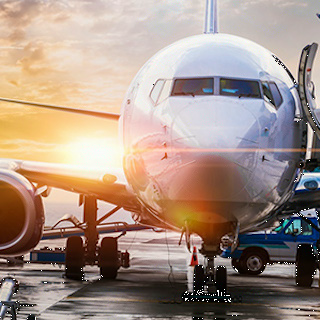

In [42]:
decode('encoded.txt', 'decoded.png')

#### Q3.3 Code: Here we calculate the loss after using the lossless quantization tables designed by ourselves during the encoding period:

In [43]:
# The two functions below are copied from the example code for designing the quantization tables.
# But in this case, we used our own tables which are all made up of value 1
def load_quantization_table(component):
    # Quantization Table for: Photoshop - (Save For Web 080)
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1]])
    elif component == 'chrom':
        q = np.array([[1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q


def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)

# The code below is copied from the example code of encoding above
image = Image.open('airplane.png')
ycbcr = image.convert('YCbCr')

npmat = np.array(ycbcr, dtype=np.uint8)

rows, cols = npmat.shape[0], npmat.shape[1]

# block size: 8x8
if rows % 8 == cols % 8 == 0:
    blocks_count = rows // 8 * cols // 8
else:
    raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))

# dc is the top-left cell of the block, ac are all the other cells
dc = np.empty((blocks_count, 3), dtype=np.int32)
ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

for i in range(0, rows, 8):
    for j in range(0, cols, 8):
        try:
            block_index += 1
        except NameError:
            block_index = 0

        for k in range(3):
            # split 8x8 block and center the data range on zero
            # [0, 255] --> [-128, 127]
            block = npmat[i:i+8, j:j+8, k] - 128

            dct_matrix = dct_2d(block)
            quant_matrix = quantize(dct_matrix,'lum' if k == 0 else 'chrom')

# We then could print the matrix before and after quantization during encoding period:
print("The matrix after DCT is: ")
print(dct_matrix)
print("The matrix after quantization is: ")
print(quant_matrix)


The matrix after DCT is: 
[[ 1.1225000e+02 -1.2172887e+01  5.7906613e+00 -7.0579994e-01
   2.2500012e+00  2.6939642e-01 -1.0455801e+00  9.2467228e-03]
 [-6.9364948e+00 -2.6029906e-01  9.7955334e-01 -1.6815630e+00
  -2.6011872e+00 -6.8816557e-03  3.9894257e-02  6.5480977e-01]
 [ 7.3253787e-01  2.9396892e-01  1.9874369e+00 -6.9920290e-01
  -1.3065630e+00 -8.6004001e-01  1.7677668e-01  1.9642374e-01]
 [ 5.6131754e+00  1.0137165e+00 -1.5042770e+00 -4.5164070e-01
  -1.2813801e+00 -5.9728551e-01  4.8616287e-01 -1.6619599e-01]
 [ 1.2499999e+00  1.3335272e+00 -2.5570831e+00  1.9918830e+00
   7.4999994e-01  1.4189987e+00 -2.9381171e-01  7.0039272e-01]
 [-1.6828684e+00  9.1619605e-01 -1.7177041e-01  1.0920542e+00
   1.6221441e+00  2.0164075e-01 -2.1098503e-01 -8.9836903e-02]
 [-8.4462321e-01 -6.6929919e-01  1.7677671e-01  6.8974853e-02
  -5.4119611e-01 -3.4675995e-01 -4.8743686e-01 -2.7108157e-01]
 [-2.3812308e+00 -3.1558504e+00 -1.3728095e+00 -3.8956499e-01
  -5.7925683e-01 -9.3156296e-01 -2.84

Then we calculate the loss between these two matrix. The results are almost equal to zero (using two decimal), which means this quantization during encoding period is lossless.

In [44]:
np.round((dct_matrix-quant_matrix),decimals=2)

array([[ 0.25, -0.17, -0.21,  0.29,  0.25,  0.27, -0.05,  0.01],
       [ 0.06, -0.26, -0.02,  0.32,  0.4 , -0.01,  0.04, -0.35],
       [-0.27,  0.29, -0.01,  0.3 , -0.31,  0.14,  0.18,  0.2 ],
       [-0.39,  0.01,  0.5 , -0.45, -0.28,  0.4 ,  0.49, -0.17],
       [ 0.25,  0.33,  0.44, -0.01, -0.25,  0.42, -0.29, -0.3 ],
       [ 0.32, -0.08, -0.17,  0.09, -0.38,  0.2 , -0.21, -0.09],
       [ 0.16,  0.33,  0.18,  0.07,  0.46, -0.35, -0.49, -0.27],
       [-0.38, -0.16, -0.37, -0.39,  0.42,  0.07, -0.28,  0.01]])

## Q4: PSNR

**TARGET**: 
1. define a function that calculates the PSNR of a pair of images
2. calculate the PSNR of the original image and the decoded image

### Solution:

In [ ]:
##########################
# !!!!!!!!! EDIT REQUIRED !!!!!!!!!!
##########################

def cal_psnr(original_image, target_image):
  # calculate the Mean-Square-Error first
  mse = np.mean((original_image/1.0 - target_image/1.0) ** 2 ) # divide by 1.0 to change to the float
   
  psnr = 10 * math.log10(255.0**2/mse)
  return psnr

original_file = 'airplane.png'
decoded_file = 'decoded.png'

# original_file = Image.open('airplane.png').convert("RGB")

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

# img_ori = img_ori.convert("RGB")

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)

# print out the pixel values and the shape of the original image (320,320,3)
# print(img_ori)
# print(img_ori.shape)

print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(img_ori, img_doc)))

The PSNR of the decoded image against the original one is 25.25190885835974


## BONUS1
**TARGET**:
1. define various quantization tables
2. get compressed images w/ tables defined
3. calculate the PSNR values of those images against the original one

### Solution: 

#### Design two new quantization tables with compressed images shown. The tables are reffered from the original tables, but we multiply the values inside by two for each time.

####1) The new defined table 1

In [ ]:
##The new defined table 1


def load_quantization_table(component):
    # Quantization Table for: Photoshop - (Save For Web 080)
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[4, 4, 4, 4, 6, 8, 10, 12],
                      [4, 4, 4, 4, 6, 8, 10, 12],
                      [4, 4, 4, 4, 8, 10, 14, 18],
                      [4, 4, 4, 8, 10, 14, 18, 24],
                      [6, 6, 8, 10, 16, 20, 24, 24],
                      [8, 8, 10, 14, 20, 24, 24, 24],
                      [10, 10, 14, 18, 24, 24, 24, 24],
                      [12, 12, 18, 24, 24, 24, 24, 24]])
    elif component == 'chrom':
        q = np.array([[6, 6, 10, 18, 26, 30, 30, 30],
                      [6, 8, 12, 22, 28, 24, 24, 24],
                      [10, 12, 18, 28, 24, 24, 24, 24],
                      [18, 22, 28, 24, 24, 24, 24, 24],
                      [26, 28, 24, 24, 24, 24, 24, 24],
                      [30, 24, 24, 24, 24, 24, 24, 24],
                      [30, 24, 24, 24, 24, 24, 24, 24],
                      [30, 24, 24, 24, 24, 24, 24, 24]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q


def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)


In [ ]:
encode('airplane.png', 'encoded.txt')

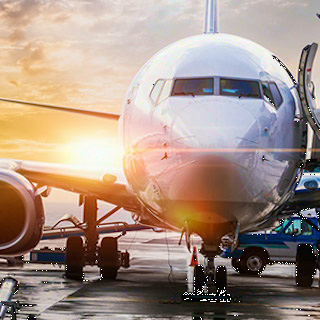

In [ ]:
decode('encoded.txt', 'decoded.png')

In [ ]:
# Calculate the PSNR
original_file = 'airplane.png'
decoded_file = 'decoded.png'

# original_file = Image.open('airplane.png').convert("RGB")

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

# img_ori = img_ori.convert("RGB")

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)

# print(cal_psnr(img_ori, img_doc)

print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(img_ori, img_doc)))

The PSNR of the decoded image against the original one is 23.96881103102391


####2) The new defined table two:

In [ ]:
##The new defined table 2


def load_quantization_table(component):
    # Quantization Table for: Photoshop - (Save For Web 080)
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[8, 8, 8, 8, 12, 16, 20, 24],
                      [8, 8, 8, 8, 12, 16, 20, 24],
                      [8, 8, 8, 8, 16, 20, 28, 36],
                      [8, 8, 8, 16, 20, 28, 36, 48],
                      [12, 12, 16, 20, 32, 40, 48, 48],
                      [16, 16, 20, 28, 40, 48, 48, 48],
                      [20, 20, 28, 36, 48, 48, 48, 48],
                      [24, 24, 36, 48, 48, 48, 48, 48]])
    elif component == 'chrom':
        q = np.array([[12, 12, 20, 36, 52, 60, 60, 60],
                      [12, 16, 24, 44, 56, 48, 48, 48],
                      [20, 24, 36, 36, 48, 48, 48, 48],
                      [36, 44, 56, 48, 48, 48, 48, 48],
                      [52, 56, 48, 48, 48, 48, 48, 48],
                      [60, 48, 48, 48, 48, 48, 48, 48],
                      [60, 48, 48, 48, 48, 48, 48, 48],
                      [60, 48, 48, 48, 48, 48, 48, 48]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q


def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)


In [ ]:
encode('airplane.png', 'encoded.txt')

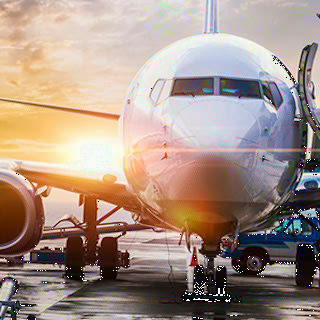

In [ ]:
decode('encoded.txt', 'decoded.png')

In [ ]:
# Calculate the PSNR
original_file = 'airplane.png'
decoded_file = 'decoded.png'

# original_file = Image.open('airplane.png').convert("RGB")

img_ori = Image.open(original_file)
img_doc = Image.open(decoded_file)

# img_ori = img_ori.convert("RGB")

img_ori = np.array(img_ori, dtype=np.float32)
img_doc = np.array(img_doc, dtype=np.float32)

# print(cal_psnr(img_ori, img_doc)

print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(img_ori, img_doc)))

The PSNR of the decoded image against the original one is 21.807276890761816


#### Bonus 1 Analysis

The above quantization tables are timed 2 or 4 with the original tables, which means during the compression more data will be omitted as the data will be divided by two larger tables, resulting in more pixels' luminance and chrominance be rounded to 0, and due to dividing larger numbers, there will be more values have decimal parts, which will be omitted during the compression process, therefore create pixels data variation.

Considering the points listed above, it can be inferred that the overall quality will be reduced when using quantization tables with larger values (where we could easily find the blurring pixels at the edge of the airplane tires), and the calculated PSNR values proved that larger values in the quantization tables will result in smaller PSNR. And this result proves our answer in Question3.2, which is "higher scalar value in the table will make us loss more information".

## BONUS2
**TARGET**:
1. Convert the color image to a gray-scale one
2. Perform the compression for this gray-scale image (encode, decode, visualize)

### Solution: 

#### 1). Convert to grey-scale image

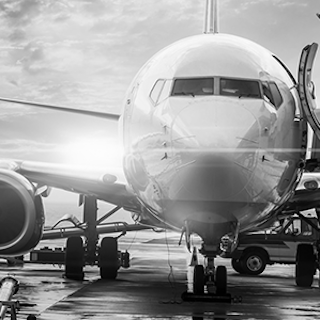

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('airplane.png').convert('L')   ##convert the image to gray scale one
img.save('greyscale_airplane.png')
display(img)

#### 2). Perform the compression for this gray-scale image

In [ ]:
encode('greyscale_airplane.png', 'encoded.txt')   ##Notice here is using the last quantization tables defined

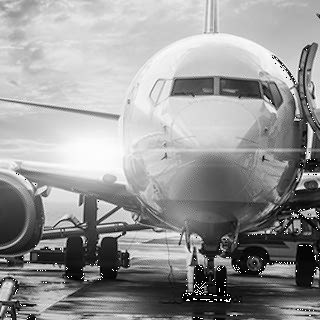

In [ ]:
decode('encoded.txt', 'greyscale_decoded.png')

The image after decoded is still one-channel greyscale image.

In [ ]:
greyscale_decoded = Image.open('greyscale_decoded.png')
print(greyscale_decoded.size)

(320, 320)


#### 3). Then calculate the PSNR of two greyscale images

In [ ]:
original_greyfile = 'greyscale_airplane.png'
original_greyfile = Image.open(original_greyfile)


# img_ori = img_ori.convert("RGB")

original_greyfile = np.array(img_ori, dtype=np.float32)
greyscale_decoded = np.array(img_doc, dtype=np.float32)

# print(cal_psnr(img_ori, img_doc)

print('The PSNR of the decoded image against the original one is {}'.format(cal_psnr(original_greyfile, greyscale_decoded)))

The PSNR of the decoded image against the original one is 21.807276890761816
